In [249]:
import pandas as pd
from datapackage import Package
import matplotlib.pyplot as plt
import numpy as np
from iso3166 import countries
import plotly.io as pio
import math
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
import os
import json

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Country Code to Country Mapping (Helper Function)

In [250]:
package = Package('https://datahub.io/core/country-list/datapackage.json')

# print list of all resources:
#print(package.resource_names)

# print processed tabular data (if exists any)
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        content = resource.read()
ISO_Alpha2_Country_Mapping = {item[1]:item[0] for item in content}
ISO_Alpha2_Country_Mapping['KR']='Korea' #From 'Korea, Republic of' to Korea

In [251]:
DF1 = pd.read_pickle("../Data/New_Video_DF_360217.pkl")
DF = pd.read_pickle("../Data/Cleaned_Data(No_Agg).pkl")

## NOTE
Our initial data set has 360217 trending videos (including multiple occuraces of some of the trending videos). However, only a subset of videos were returned through API call(266546 videos, including multiple occuraces of some of the trending videos). We are keeping only this subset for our feature studies as keeping the original set is sparse with multiple NaN values. Unless otherwise mentioned, the shorter(na removed) version of the data will be used for analysis. Please note that we have compared the analysis on both the Data wherever possible and they produce similar results 

In [252]:
DF1 = pd.read_pickle("../Data/New_Video_DF_360217.pkl")
DF = pd.read_pickle("../Data/Cleaned_Data(No_Agg).pkl")

Data_Lost = pd.DataFrame(DF1['country'].value_counts()).join(DF['viewing_country'].value_counts())
Data_Lost.columns=['Before', 'After']
Data_Lost['%Loss']=100*Data_Lost['After']/Data_Lost['Before']

Data_Lost

Data_Original = pd.DataFrame(100*Data_Lost['Before'].copy()/Data_Lost['Before'].sum())
Data_Original.columns=['% of occupation in data']
Data_Original['Total'] = Data_Lost['Before']

Data_Selected = pd.DataFrame(100*Data_Lost['After'].copy()/Data_Lost['After'].sum())
Data_Selected.columns=['% of occupation in data']
Data_Selected['Total'] = Data_Lost['After']

,Before,After,%Loss
US,40859,36783,90.024230
CA,40834,32753,80.210119
DE,40812,30985,75.921298
FR,40690,29274,71.943967
RU,40101,28592,71.299968
MX,39857,24316,61.008104
GB,38663,33643,87.016010
IN,32252,24667,76.482079
KR,31715,17945,56.582059
JP,14434,7588,52.570320


# How Language affects Trending ?

**INSIGHTS**

* **As we would expect, The local language seems to play a big role in trending**
* **We studies the ratio of languages of trending videos across countries (English is Top3 for all except Russia, Japan and Korea)**
* **Only in Great Britain and United States, videos trend significantly more than other countries. Similarly,  English videos trend significantly more than other languages**

In [253]:
DF['Lang'].fillna('Unknown', inplace=True)

In [254]:
DF['Lang'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)


### Which Language Trended the most in which countries?

In [255]:
Country_Vs_Lang_Table = DF.groupby(['viewing_country', 'Lang'])['video_id'].count().unstack()
Country_Vs_Lang_Table = Country_Vs_Lang_Table.fillna(value=0).astype('int64')

In [256]:
def toppers(x, how_many=3):
    toppers = {key:x.to_dict()[key] for key in sorted(x.to_dict(), key=lambda y: x.to_dict()[y], reverse=True)[:how_many]}
    toppers.update({'Other':x.sum() - sum(toppers.values())})
    return toppers

Outer = Country_Vs_Lang_Table.sum(axis=1)

Inner = Country_Vs_Lang_Table.apply(lambda x:toppers(x,2), axis=1)   

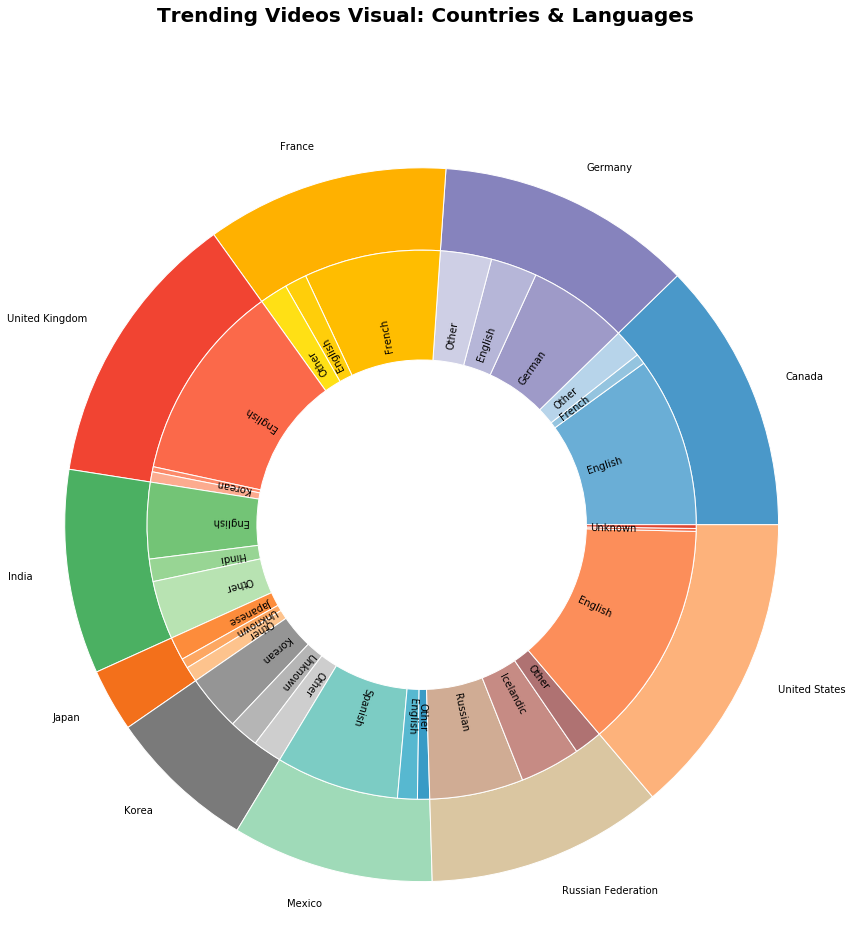

In [257]:
fig, axis = plt.subplots(figsize = (12,12))
_=axis.axis('equal')
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges , plt.cm.Greys, plt.cm.GnBu_r, plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

#Outer pie
labels = [ISO_Alpha2_Country_Mapping[cc] for cc in Outer.index]
pie1= axis.pie(Outer, labels=labels, colors=colors,radius=1.3)  
_=plt.setp(pie1[0], width=0.3, edgecolor='white' )

#Inner pie
names = list(np.array([list(item) for item in Inner.map(lambda x: x.keys()).to_list()]).flatten())
values = list(np.array([list(item) for item in Inner.map(lambda x: x.values()).to_list()]).flatten())
colors = []
for color in color_range:
    colors = colors + [color(i) for i in [0.5,0.4,0.3]]
pie2 = axis.pie(values, radius=1.3-0.3, labels=names, labeldistance=0.7, colors=colors)
_=plt.setp(pie2[0], width=0.4, edgecolor='white')
_=plt.margins(0,0)

# do the rotation of the labels
for w, t in zip(pie2[0], pie2[1]):
    mang =(w.theta1 + w.theta2)/2.  # get mean_angle of the wedge
    #print(mang, t.get_rotation())
    _=t.set_rotation(mang)         # rotate the label by (mean_angle + 270)
    _=t.set_va("center")
    _=t.set_ha("center")
    _=t.set
#Tiding up the clutter
_=pie2[1][11].set_visible(False)
_=pie2[1][-1].set_visible(False)
_=axis.axis('equal')

_=plt.suptitle('Trending Videos Visual: Countries & Languages', fontsize=20, weight='bold', y=1.1)

_=plt.tight_layout()
_= plt.savefig('../Image/Lang1.png', bbox_inches = "tight" )
_=plt.show()


# Is there any difference in popularity for trending (longevity) across countries ?

* **Only in Great Britain and United States, videos trend significantly more than other countries. Similarly,  English videos trend significantly more than other languages**

* Note:- Data used is the original version as there was no NaN's for the Viewing Countries

In [258]:
DF = DF1.groupby(['video_id', 'country'])['trending_date'].count().reset_index()
DF.columns = ['video_id','viewing_country','Total_Trend_Days']

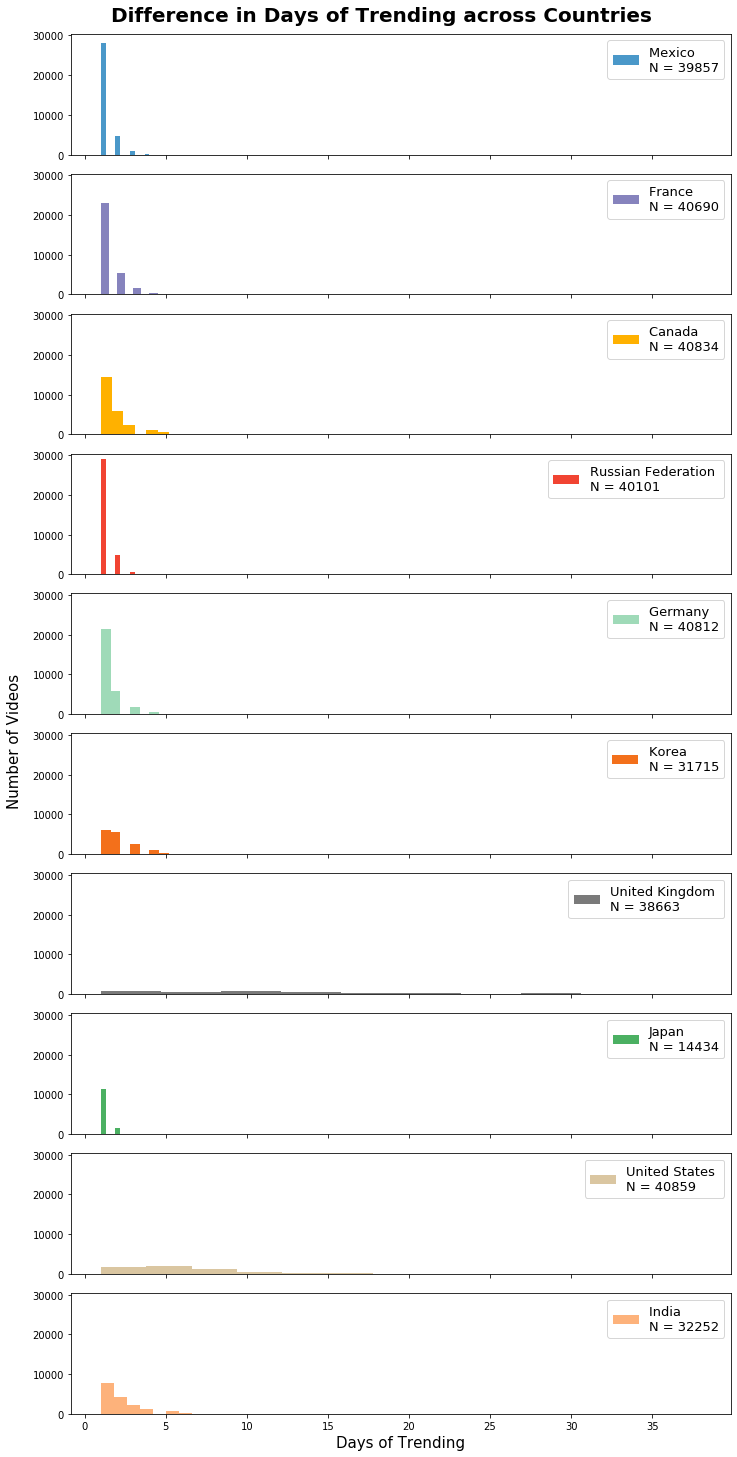

In [259]:
List_of_CCs = DF['viewing_country'].unique()

fig, axs = plt.subplots(10, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10,20))

color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,cc in enumerate(List_of_CCs):
    _=axs[index].hist(DF[DF['viewing_country']==cc]['Total_Trend_Days'], color=colors[index], alpha=1, label=f"{ISO_Alpha2_Country_Mapping[cc]} \nN = {Data_Original.loc[cc, 'Total']}")

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 13)
    

    
_=plt.suptitle('Difference in Days of Trending across Countries', fontsize=20, weight='bold', y=1.01) 
#xlabel, ylabel
_=plt.xlabel('Days of Trending',fontsize = 15)
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
_= plt.savefig('../Image/Popularity_Across_Countries_with_360217.png', bbox_inches = "tight" )
plt.show()

# Is there any difference in popularity for trending (longevity) across languages ?

* **English videos trend significantly more than other languages**

In [260]:
DF = pd.read_pickle('../Data/Popularity_DF.pkl')

In [261]:
DF['Language'].fillna('Unknown', inplace=True)
DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)
Language_Count = pd.DataFrame(DF['Language'].value_counts())

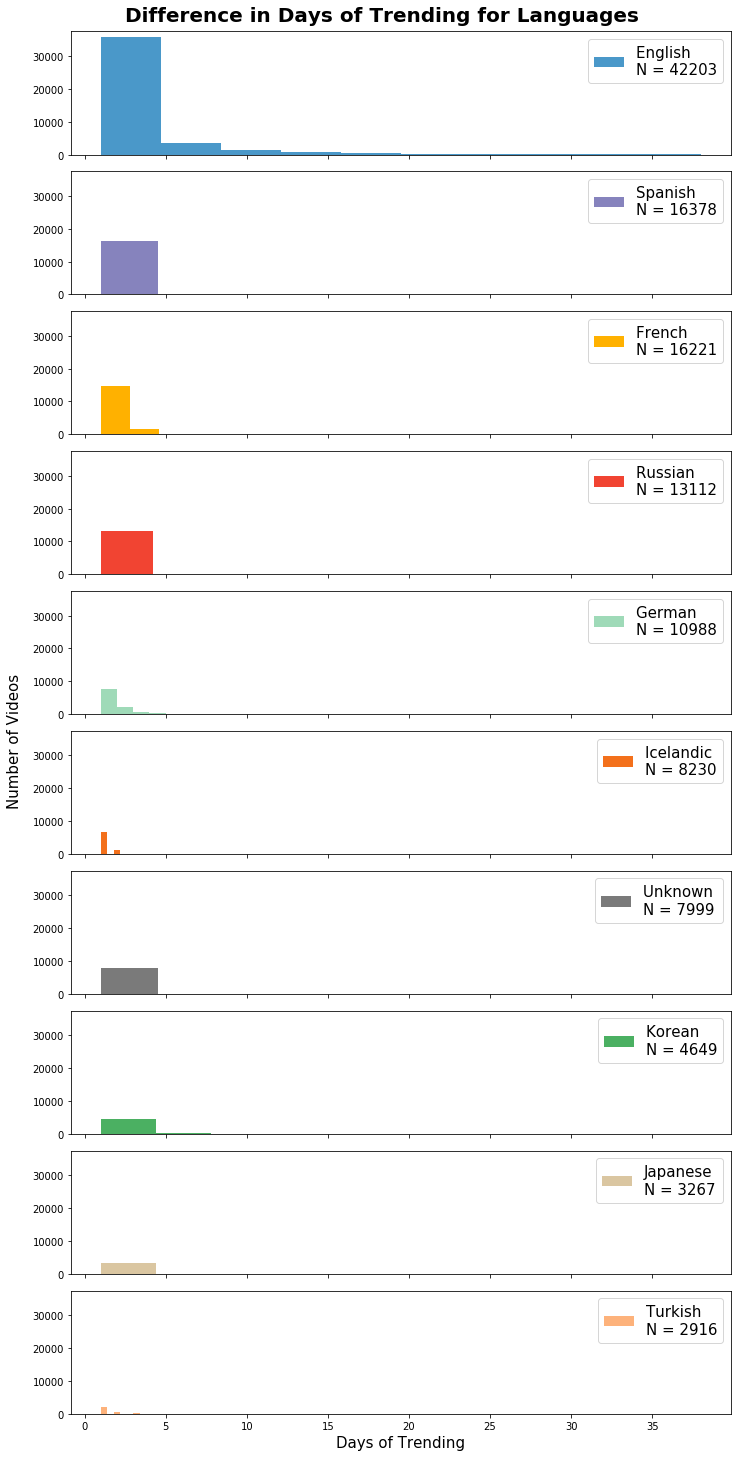

In [262]:
Top10 = Language_Count.index[:10]

fig, axs = plt.subplots(10, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10,20))

color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,lang in enumerate(Top10):
    _=axs[index].hist(DF[DF['Language']==lang]['Total_Trend_Days'], color=colors[index], alpha=1, label=f"{lang} \nN = {Language_Count.loc[lang, 'Language']}")

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 15)
    

    
_=plt.suptitle('Difference in Days of Trending for Languages', fontsize=20, weight='bold', y=1.01) 
#xlabel, ylabel
_=plt.xlabel('Days of Trending',fontsize = 15)
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
_= plt.savefig('../Image/Popularity_for_Languages.png', bbox_inches = "tight" )
plt.show()

# How similar countries are in terms of their taste in trending videos ?

* We mapped courtiers into large dimensional vectors and measured cosine similarity (similar results with Jaccard similarity matrix too) between them to understand with countries watch the same content. It appears that all countries watch mostly distinct videos. However, if we see the most prominent relationships (highest match), results are astonishing!! When, we take only countries with at least 10% similarity, it shows Canada is similar to all other interconnected countries. This shows cross culture links in Canada (possibly Immigration)

* Note:- Data used is the original version as there was no NaN's for the Viewing Countries

In [263]:
DF = DF1.groupby(['video_id', 'country'])['trending_date'].count().reset_index()
DF.columns = ['video_id','viewing_country','Total_Trend_Days']

In [264]:
Country_Video_Table = DF.groupby('viewing_country').aggregate(Video_List = ('video_id', lambda x: x.to_list()))


In [265]:
Country_Video_Table.index = [ISO_Alpha2_Country_Mapping[cc] for cc in Country_Video_Table.index]
Country_Video_Table

,Video_List
Canada,"[--45ws7CEN0, --7vNbh4UNA, --MtKsH5oBY, --YgtV..."
Germany,"[--7vNbh4UNA, --I0aj8MUdU, --MtKsH5oBY, --moh3..."
France,"[--2K8l6BWfw, --728h8mnDY, --8-sr76Haw, --DqT_..."
United Kingdom,"[--uXQQ0h-yQ, -3VBPAZPTQI, -43MBOJnVks, -5WBCr..."
India,"[-0N9r10xb_0, -0WuM6ctLHg, -0mcgX4ro7I, -0neBE..."
Japan,"[-000V8w3RbI, -09XygZcXEU, -0Gd9DBh3W4, -0S2Gw..."
Korea,"[--97zv6Db3Q, -0Jw4AU9IKQ, -0SxwCD7Uc4, -0YMxu..."
Mexico,"[--1skHapGUc, --45ws7CEN0, --6vcer7XYQ, -01qCO..."
Russian Federation,"[--45ws7CEN0, --9LvCHDHYQ, -07PqRbugOM, -0Zl7W..."
United States,"[-0CMnp02rNY, -0NYY8cqdiQ, -1Hm41N0dUs, -1yT-K..."


In [266]:
def Cosine_Similarity_Matrix(Table):
    N = Table.index.to_list()
    Sim_Matrix = pd.DataFrame(index=N, columns=N)
    for row in N:
        for col in N:
            Num = len(set(Table.loc[row][0]).intersection(set(Table.loc[col][0])))
            Denom = np.sqrt(len(Table.loc[row][0])*len(Table.loc[col][0]))
            Sim_Matrix.loc[row,col] = Num/Denom
    Sim_Matrix = Sim_Matrix.astype('float') 
    return Sim_Matrix

def Jaccard_Similarity_Matrix(Table):
    N = Table.index.to_list()
    Sim_Matrix = pd.DataFrame(index=N, columns=N)
    for row in N:
        for col in N:
            Num = len(set(Table.loc[row][0]).intersection(set(Table.loc[col][0])))
            Denom = len(set(Table.loc[row][0]).union(set(Table.loc[col][0])))
            Sim_Matrix.loc[row,col] = Num/Denom
    Sim_Matrix = Sim_Matrix.astype('float') 
    return Sim_Matrix
    

,Canada,Germany,France,United Kingdom,India,Japan,Korea,Mexico,Russian Federation,United States
Canada,1.000000,0.197145,0.153132,0.107190,0.072494,0.033306,0.030298,0.061175,0.020505,0.181839
Germany,0.197145,1.000000,0.133700,0.053791,0.036183,0.021948,0.017445,0.049535,0.062124,0.080388
France,0.153132,0.133700,1.000000,0.043843,0.041129,0.021304,0.015537,0.045574,0.029110,0.046030
United Kingdom,0.107190,0.053791,0.043843,1.000000,0.014116,0.014789,0.019872,0.039297,0.017015,0.222950
India,0.072494,0.036183,0.041129,0.014116,1.000000,0.010274,0.005722,0.016947,0.005754,0.022515
Japan,0.033306,0.021948,0.021304,0.014789,0.010274,1.000000,0.034611,0.015346,0.007943,0.015141
Korea,0.030298,0.017445,0.015537,0.019872,0.005722,0.034611,1.000000,0.010892,0.006349,0.014755
Mexico,0.061175,0.049535,0.045574,0.039297,0.016947,0.015346,0.010892,1.000000,0.013017,0.039921
Russian Federation,0.020505,0.062124,0.029110,0.017015,0.005754,0.007943,0.006349,0.013017,1.000000,0.013495
United States,0.181839,0.080388,0.046030,0.222950,0.022515,0.015141,0.014755,0.039921,0.013495,1.000000


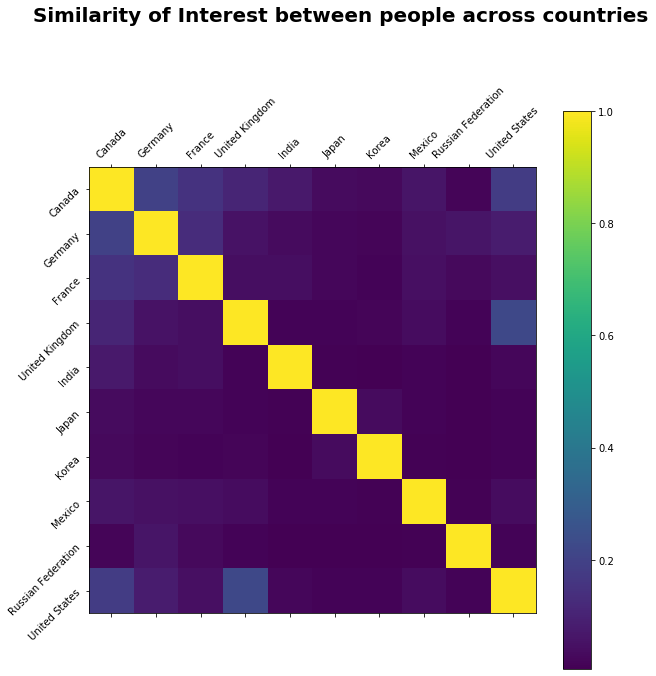

In [267]:
Similarity = Cosine_Similarity_Matrix(Country_Video_Table)
Similarity

_=plt.figure(figsize=(10,10))
_=plt.matshow(Similarity, fignum=1)
_=plt.xticks(range(len(Similarity.columns)), Similarity.columns, rotation=45)
_=plt.yticks(range(len(Similarity.columns)), Similarity.columns, rotation=45)
_=plt.colorbar()
_=plt.suptitle('Similarity of Interest between people across countries', fontsize=20, weight='bold', y=1.01) 
_= plt.savefig('../Image/Correlation_on_video_watch_with_360217.png')
_=plt.show()

,Canada,Germany,France,United Kingdom,India,Japan,Korea,Mexico,Russian Federation,United States
Canada,1.000000,0.108787,0.082350,0.035823,0.036830,0.016097,0.015026,0.031149,0.010210,0.079434
Germany,0.108787,1.000000,0.071630,0.016352,0.017620,0.010194,0.008383,0.025347,0.031970,0.031615
France,0.082350,0.071630,1.000000,0.013119,0.019981,0.009829,0.007423,0.023293,0.014745,0.017676
United Kingdom,0.035823,0.016352,0.013119,1.000000,0.005292,0.005973,0.007535,0.011308,0.004819,0.118064
India,0.036830,0.017620,0.019981,0.005292,1.000000,0.005128,0.002869,0.008017,0.002697,0.010215
Japan,0.016097,0.010194,0.009829,0.005973,0.005128,1.000000,0.017515,0.006924,0.003553,0.007169
Korea,0.015026,0.008383,0.007423,0.007535,0.002869,0.017515,1.000000,0.005112,0.002961,0.006711
Mexico,0.031149,0.025347,0.023293,0.011308,0.008017,0.006924,0.005112,1.000000,0.006551,0.014826
Russian Federation,0.010210,0.031970,0.014745,0.004819,0.002697,0.003553,0.002961,0.006551,1.000000,0.004924
United States,0.079434,0.031615,0.017676,0.118064,0.010215,0.007169,0.006711,0.014826,0.004924,1.000000


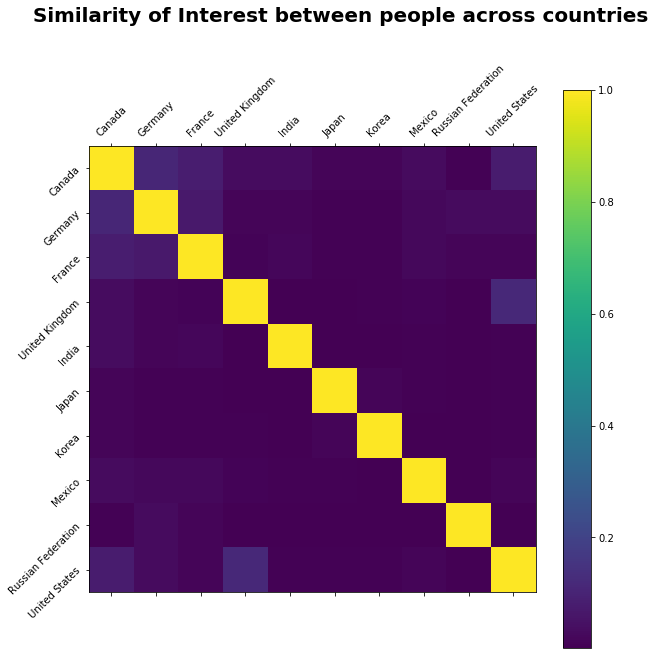

In [268]:
Similarity2 = Jaccard_Similarity_Matrix(Country_Video_Table)
Similarity2

_=plt.figure(figsize=(10,10))
_=plt.matshow(Similarity2, fignum=1)
_=plt.xticks(range(len(Similarity2.columns)), Similarity.columns, rotation=45)
_=plt.yticks(range(len(Similarity2.columns)), Similarity.columns, rotation=45)
_=plt.colorbar()
_=plt.suptitle('Similarity of Interest between people across countries', fontsize=20, weight='bold') 
#_= plt.savefig('../Image/Correlation_on_video_watch_with_360217.png')
_=plt.show()

In [269]:
Country_ISO_Dict = {val:key for key,val in ISO_Alpha2_Country_Mapping.items()}
Country_similarity = dict()
for i,j in zip(*np.where(Similarity>=0.1)):
    if (i!=j):
        Country_similarity[Country_ISO_Dict[Similarity.index[i]]]=Country_similarity.get(Country_ISO_Dict[Similarity.index[i]], [])+[Country_ISO_Dict[Similarity.index[j]]]
        
Country_similarity #Will be used later for censorship analysis 

{'CA': ['DE', 'FR', 'GB', 'US'],
 'DE': ['CA', 'FR'],
 'FR': ['CA', 'DE'],
 'GB': ['CA', 'US'],
 'US': ['CA', 'GB']}

In [270]:
Sorted_Similarity = Similarity.stack().sort_values(ascending=False)

In [271]:
Morethan10perc = Sorted_Similarity[Sorted_Similarity!=1][Sorted_Similarity[Sorted_Similarity!=1]>=0.1].reset_index()

In [272]:
Morethan10perc.reset_index(inplace=True)
Morethan10perc.columns = ['index', 'countries', 'relationship', 'similarity']

In [273]:
Morethan10perc['relationship'] = Morethan10perc.apply(lambda x: "Relationship: {}".format(x['index']//2 + 1), axis=1)

In [274]:
Morethan10perc['iso_code'] = Morethan10perc['countries'].map(Country_ISO_Dict)
Morethan10perc['iso_code_alpha3'] = Morethan10perc['iso_code'].map(lambda x: [item for item in countries.get(x)][2])
Country_RelationShip_Dict = Morethan10perc.groupby('countries').aggregate(relationships =  ('relationship', lambda x: '\n'.join(x.to_list()))).to_dict()['relationships']   
Morethan10perc['relationships'] = Morethan10perc['countries'].map(lambda x: "{}: {}".format(x, Country_RelationShip_Dict[x]))


In [275]:
import plotly.express as px

fig = px.line_geo(Morethan10perc, hover_name= 'relationships',locations="iso_code_alpha3",
                  color="relationship",
                  projection="equirectangular")

pio.write_html(fig, file='../Image/Conuntry_Similarity_based_on_what_is_trending_with_360217.html', auto_open=False)
#'equirectangular', 'orthographic'

fig.show()

# What categories are trended in which coutries? Is there a similarity?

* **We studied trending categories across countries and found "Entertainment" is the most trending category in all countries except Great Britain(GB) and Russia. In GB, Music outnumbered the Entertainment whereas in Russia "People & Blogs" surmounted Entertainment!** 

* **We clustered countries based on the how much they watch in each categories. The clustering method we chose is hierarchical clustering as we have only 10 countries to compare**
 - **Cluster1 - Canada, Germany,and India - Common interest in Entertainment, News & Politics**
 - **Cluster2 - Japan, Mexico & France - Common interest in Entertainment, People&Blogs, Sports**
 - **Cluster3 - Korea & Russia - Common interest in Entertainment, News & Politics, People&Blogs**
 - **Cluster4 - UK & US - Common interest in Entertainment, Music**
 
* Note:- Data used is the original version as there was no NaN's for the Viewing Countries and Categories.

In [276]:
#Cleanup on the original DF
DF1 = pd.read_pickle("../Data/New_Video_DF_360217.pkl")
DF1.rename(columns={'country':'viewing_country'}, inplace=True)

List_of_JSON = [(file, file.split('_')[0]) for file in list(os.walk(os.path.join('..', 'Data')))[0][-1] if (file.endswith("category_id.json"))]   
Dict_Catogory = dict()
file = 'US_category_id.json'
with open(os.path.join('..', 'Data', file)) as f:
    data = json.load(f)
    Dict_Catogory.update({int(item['id']): item['snippet']['title'] for item in data['items']})
#Dict_Catogory

DF1['Category'] = DF1['category_id'].map(Dict_Catogory)
DF1.drop('category_id', axis=1, inplace=True)

DF = DF1.copy()

In [277]:
Country_Vs_Cat_Table = DF.groupby(['viewing_country', 'Category'])['video_id'].count().unstack()
Country_Vs_Cat_Table = Country_Vs_Cat_Table.fillna(value=0).astype('int64')

In [278]:
def toppers(x, how_many=3):
    toppers = {key:x.to_dict()[key] for key in sorted(x.to_dict(), key=lambda y: x.to_dict()[y], reverse=True)[:how_many]}
    toppers.update({'Other':x.sum() - sum(toppers.values())})
    return toppers

Outer = Country_Vs_Cat_Table.sum(axis=1)

Inner = Country_Vs_Cat_Table.apply(lambda x:toppers(x,4), axis=1)   

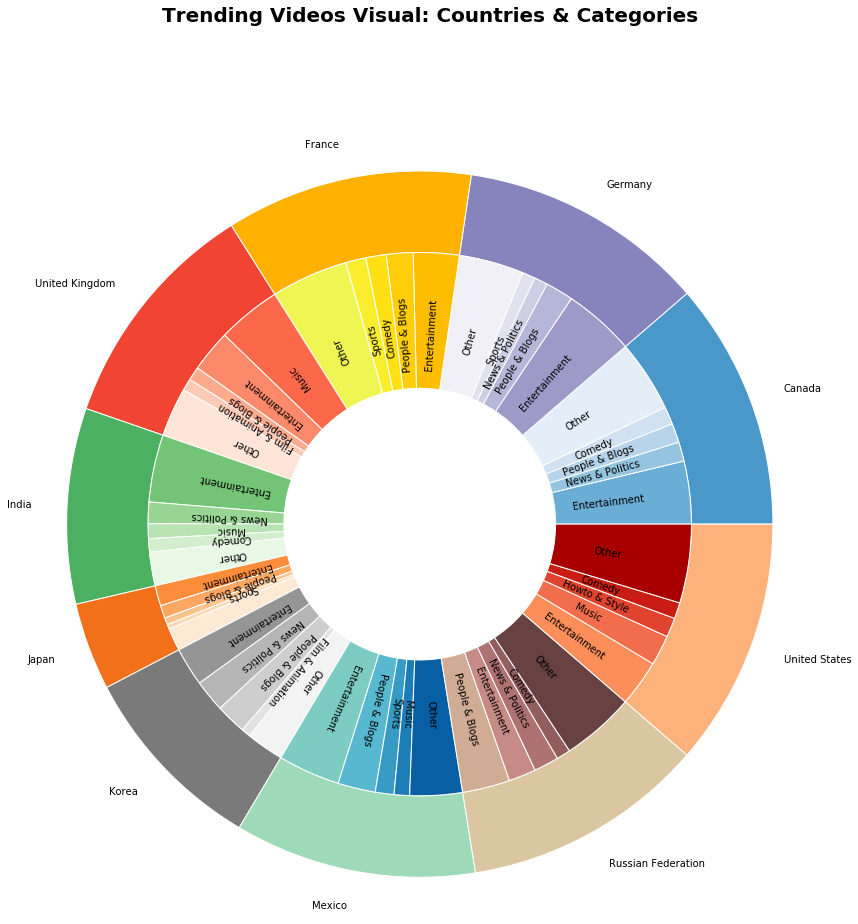

In [279]:
fig, axis = plt.subplots(figsize = (12,12))
_=axis.axis('equal')
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges , plt.cm.Greys, plt.cm.GnBu_r, plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

#Outer pie
labels = [ISO_Alpha2_Country_Mapping[cc] for cc in Outer.index]
pie1= axis.pie(Outer, labels=labels, colors=colors,radius=1.3)  
_=plt.setp(pie1[0], width=0.3, edgecolor='white' )

#Inner pie
names = list(np.array([list(item) for item in Inner.map(lambda x: x.keys()).to_list()]).flatten())
values = list(np.array([list(item) for item in Inner.map(lambda x: x.values()).to_list()]).flatten())
colors = []
for color in color_range:
    colors = colors + [color(i) for i in [0.5,0.4,0.3,0.2,0.1]]
pie2 = axis.pie(values, radius=1.3-0.3, labels=names, labeldistance=0.7, colors=colors)
_=plt.setp(pie2[0], width=0.5, edgecolor='white')
_=plt.margins(0,0)

# do the rotation of the labels
for w, t in zip(pie2[0], pie2[1]):
    mang =(w.theta1 + w.theta2)/2.  # get mean_angle of the wedge
    #print(mang, t.get_rotation())
    _=t.set_rotation(mang)         # rotate the label by (mean_angle + 270)
    _=t.set_va("center")
    _=t.set_ha("center")
    _=t.set
#Tiding up the clutter
#_=pie2[1][27].set_visible(False)
_=pie2[1][28].set_visible(False)
_=pie2[1][29].set_visible(False)

_=axis.axis('equal')

_=plt.suptitle('Trending Videos Visual: Countries & Categories', fontsize=20, weight='bold', y=1.1)

_=plt.tight_layout()
_= plt.savefig('../Image/Cat1_with_360217.png', bbox_inches = "tight" )
_=plt.show()

# Clustering of Countries based on the categories

In [280]:
from sklearn.preprocessing import normalize
#It normalize each sample (Row wise)
scaled_country = normalize(Country_Vs_Cat_Table)
scaled_country = pd.DataFrame(scaled_country, columns=Country_Vs_Cat_Table.columns, index=Country_Vs_Cat_Table.index)

array([3, 3, 1, 0, 3, 1, 2, 1, 2, 0])

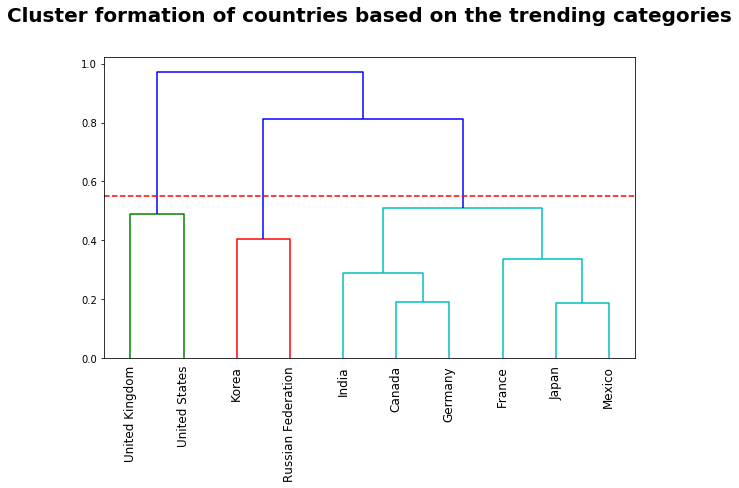

In [281]:
import scipy.cluster.hierarchy as shc
_=plt.figure(figsize=(10, 7))  
_=plt.title("Cluster formation of countries based on the trending categories", fontsize=20, weight='bold', y=1.1)  
dend = shc.dendrogram(shc.linkage(scaled_country, method='ward'))
_=plt.axhline(y=0.55, color='r', linestyle='--')
_=plt.xticks(plt.xticks()[0], [ISO_Alpha2_Country_Mapping[scaled_country.index[id]] for id in dend['leaves']], rotation=90)

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(scaled_country)

_=plt.tight_layout()
_= plt.savefig('../Image/Country_cluster_based_on_categories_with_360217.png', bbox_inches = "tight" )
_=plt.show()

In [282]:
Country_Cluster = pd.DataFrame(Country_Vs_Cat_Table.reset_index()['viewing_country'])
Country_Cluster['Country'] = Country_Cluster['viewing_country'].map(ISO_Alpha2_Country_Mapping)
Country_Cluster['iso_code_alpha3'] = Country_Cluster['viewing_country'].map(lambda x: [item for item in countries.get(x)][2])

Country_Cluster['Cluster'] = cluster.fit_predict(scaled_country)


In [283]:
import plotly.express as px

fig = px.choropleth(Country_Cluster, locations="iso_code_alpha3",
                    color="Cluster",
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

pio.write_html(fig, file='../Image/Country_Clusters_based_on_what_categories_are_trending_with_360217.html', auto_open=False)

# Is there any difference in popularity (longevity) across categories ?

**We define popularity(longevity) as the number the days of trending**
- **Almost all categories have a varying popularity**
- **However, it looks like "Non-profit & Activism" tend to have relatively shorter limelight**
- **Note that "Trailers" are only 2 in the dataset. Hence, it is not enough evidence to say that, they trend less

Note:- Data used is the cleaned(shorter) version as we would be using the shorter version for model building as it is devoid of NaNs for a wide variety of features. Hence, we need to analyse the factors affecting popularity with the same Data

In [284]:
DF = pd.read_pickle('../Data/Popularity_DF.pkl')

DF['Language'].fillna('Unknown', inplace=True)
DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)

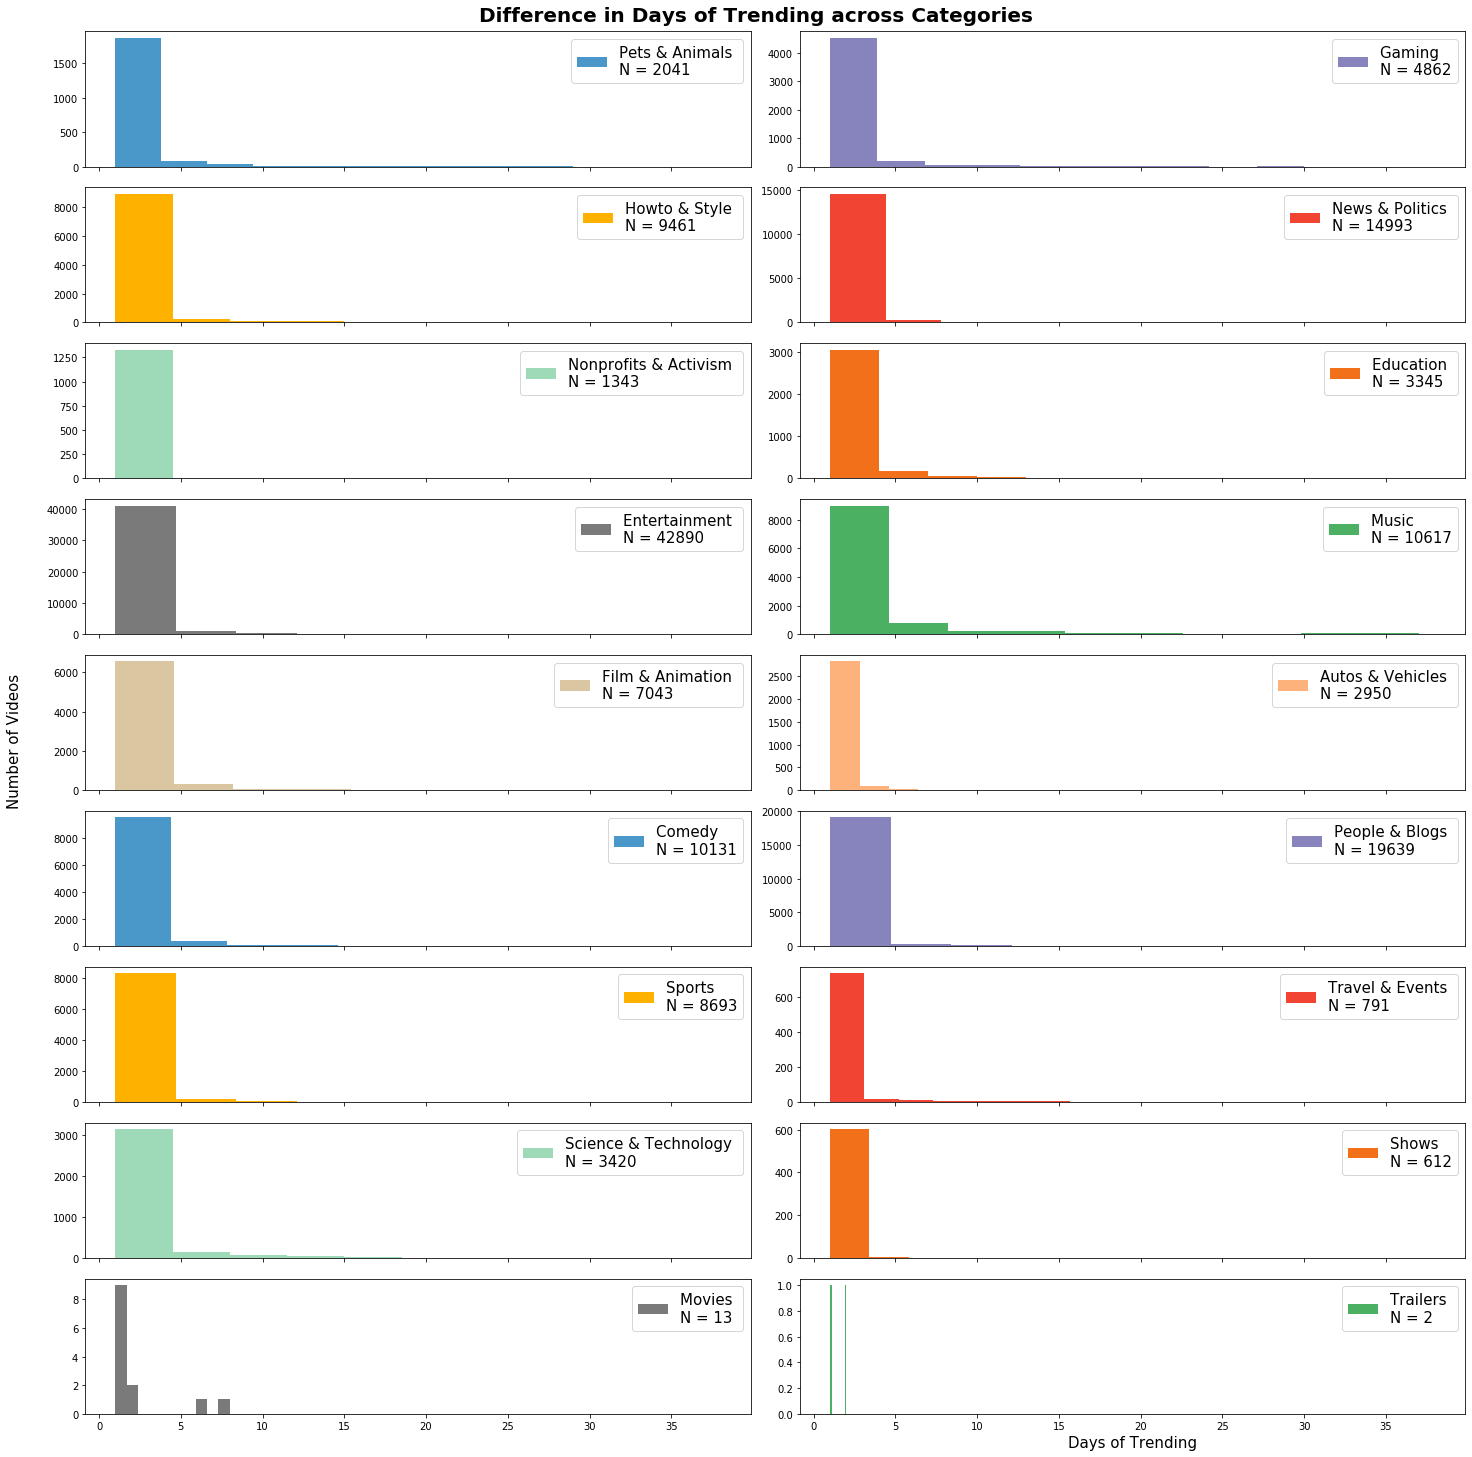

In [285]:
List_of_Cats = DF['Category'].unique()
Category_Count = pd.DataFrame(DF['Category'].value_counts())

fig, axs = plt.subplots(9, 2, sharex=True, sharey=False, tight_layout=True, figsize=(20,20))
axs = axs.ravel()
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,cat in enumerate(List_of_Cats):
    _=axs[index].hist(DF[DF['Category']==cat]['Total_Trend_Days'], color=colors[index%10], alpha=1, label=f"{cat} \nN = {Category_Count.loc[cat, 'Category']}")

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 15)
    

    
_=plt.suptitle('Difference in Days of Trending across Categories', fontsize=20, weight='bold', y=1.01) 
#xlabel, ylabel
_=plt.xlabel('Days of Trending',fontsize = 15)
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
_= plt.savefig('../Image/Popularity_Across_Categories.png', bbox_inches = "tight" )
plt.show()

# Feature Selection of Categorical Variables

**We used statistical measures to understand the prominent features (attributes) that affects popularity (No. of days to trend)**
- **Used Chi-squared Feature Selection for categorical features**
- **Use ANOVA test for numeric features**
**Please note that this study is a preliminary one and doesn't identify the combined effects of attributes on output**


## Chi-Squared Feature Selection function

In [286]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# prepare input data
def encode(X):
    oe = OrdinalEncoder()
    oe.fit(X) 
    return oe


def feature_selection(DF, function, ravel=False):
    
    columns = DF.columns
    #Create separate encoders for input and output
    encoder_X = encode(DF[columns[:-1]])
    X = encoder_X.transform(DF[columns[:-1]])

    encoder_Y = encode(DF['Popularity_Category'].to_numpy().reshape(-1,1))
    Y = encoder_Y.transform(DF['Popularity_Category'].to_numpy().reshape(-1,1))
    if ravel:
        Y=Y.ravel()
    fs = SelectKBest(score_func=function, k='all')
    fs.fit(X, Y)
    
    # what are scores for the features
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))
    # plot the scores
    _=plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    _=plt.xticks([i for i in range(len(fs.scores_))], columns[:-1], rotation=90)
    plt.show()
    
    return fs.scores_


In [287]:
def Basic_Cleanup():
    DF = pd.read_pickle('../Data/Popularity_DF.pkl')

    #Language fill NaN and cleanup
    DF['Language'].fillna('Unknown', inplace=True)
    DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)

    Country_Category_Popularity_DF = DF[['viewing_country', 'Category', 'Origin_Country', 'Language', 'Comments_Disabled', 'Ratings_Disabled', 'Blocked', 'Allowed', 'GoogleAnalyticsUsed', 'IsmoderatingComments', 'Total_Trend_Days']].copy()

    #import missingno as msno
    #_=msno.matrix(Country_Category_Popularity_DF)
    #Origin_Country fill NaN and cleanup
    Country_Category_Popularity_DF['Origin_Country'].fillna(value='Not_Disclosed', inplace=True)
    return Country_Category_Popularity_DF


def map_to_cat(x):
    #np.quantile(Country_Category_Popularity_DF['Total_Trend_Days'], [0.95, 0.999])
    #1 -> 'JustTrending'
    #(1 to 5] -> 'Popular' #5 is 95th %
    #(5 to 14] -> 'UlraPopular' #14 is 99.1%
    #>14 -> 'Phenomenon'
    return ('JustTrending' if x==1 else ('Popular' if x<=5 else ('UltraPopular' if x<=14 else "Phenomenon")))

Feature 0: 9136.199843
Feature 1: 1763.807408
Feature 2: 26352.847353
Feature 3: 49299.231133
Feature 4: 126.115758
Feature 5: 91.221857
Feature 6: 133.616390
Feature 7: 72.862969
Feature 8: 121.805762


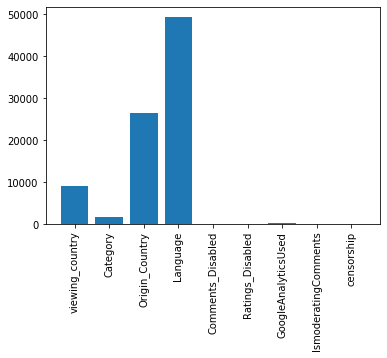

array([ 9136.19984317,  1763.80740809, 26352.84735332, 49299.23113338,
         126.11575757,    91.22185733,   133.61638978,    72.86296909,
         121.80576155])

In [288]:
#Retrieve Country_Category_Popularity_DF after basic cleanup
Country_Category_Popularity_DF = Basic_Cleanup()
#Derive a new variable censorship if any blocking
Country_Category_Popularity_DF['censorship'] = Country_Category_Popularity_DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      
Country_Category_Popularity_DF.drop(['Blocked', 'Allowed', 'Total_Trend_Days'], inplace=True, axis=1)

feature_selection(Country_Category_Popularity_DF, chi2)
#_=msno.matrix(Country_Category_Popularity_DF)

## Feature Selection of Numeric Variables  (ANOVA Test)

Feature 0: 200.768561
Feature 1: 406.064902
Feature 2: 5835.287534
Feature 3: 5480.808362
Feature 4: 2524.251736
Feature 5: 3911.372618
Feature 6: 1015.285355


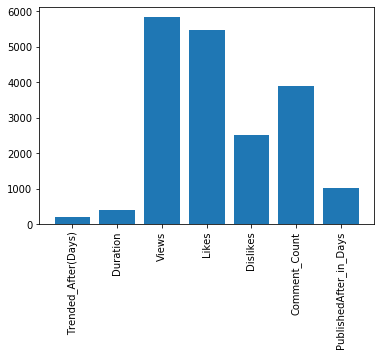

array([ 200.76856128,  406.06490198, 5835.28753387, 5480.80836217,
       2524.25173613, 3911.37261773, 1015.28535524])

In [289]:
def indays(x,y):
    z=x.date()-y.date()
    return z.days
def Basic_Cleanup_Numeric():
    DF = pd.read_pickle('../Data/Popularity_DF.pkl')

    DF['Trended_After(Days)'] = DF.apply(lambda x: indays(x['First_Trending'],x['Publish_Time']), axis=1)

    Country_Category_Popularity_DF = DF[['viewing_country', 'Trended_After(Days)','Duration', 'Views', 'Likes', 'Dislikes', 'Comment_Count', 'PublishedAfter_in_Days', 'Blocked', 'Allowed', 'Total_Trend_Days']].copy()
    
    
    Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      
    Country_Category_Popularity_DF.drop(['viewing_country', 'Blocked', 'Allowed', 'Total_Trend_Days'], inplace=True, axis=1)

    return Country_Category_Popularity_DF


#Retrieve Country_Category_Popularity_DF after basic cleanup
Country_Category_Popularity_DF = Basic_Cleanup_Numeric()

feature_selection(Country_Category_Popularity_DF, f_classif, ravel=True)
#_=msno.matrix(Country_Category_Popularity_DF)

# Study on Boolean Categorical Variables

* **Based on the feature selection study, it appears that Boolean Categorical variables are less significant than others**

* **In this section, we study if they are any significant at all**

In [290]:
Country_Category_Popularity_DF = DF[['viewing_country', 'Category', 'Origin_Country', 'Language', 'Comments_Disabled', 'Ratings_Disabled', 'Blocked', 'Allowed', 'GoogleAnalyticsUsed', 'IsmoderatingComments', 'Total_Trend_Days']].copy()
Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      

def plot_popularity_distribution(col, text, filename, legend=None, title=None):
    #col:- Column name in Country_Category_Popularity_DF you want to analyse the significance for
    #text:- text in the graph
    #filename:- filename to save
    #legend:- legend names as a list
    
    contingency_table=Country_Category_Popularity_DF.groupby(col)['Popularity_Category'].value_counts().unstack()
    
    stat, p, dof, expected = chi2_contingency(contingency_table)


    # interpret p-value
    alpha = 0.01
    if p <= alpha:
        print(f'Popularity depends on {col} (reject H0)')
    else:
        print(f'Popularity is independent of {col} (fail to reject H0)')
    
    DF=pd.DataFrame(Country_Category_Popularity_DF.groupby(col)['Popularity_Category'].value_counts(normalize=True))
    DF.columns = ['Percentage']
    DF = DF.unstack(level=0)
    DF = DF.loc[['JustTrending', 'Popular', 'UltraPopular', 'Phenomenon'],:]
    DF['Percentage']=DF['Percentage']*100

    DF.columns.name = col
    if legend==None:
        DF.columns = [col[1] for col in DF.columns]
    else:
        DF.columns = legend
        
    yTicks = np.arange(0, (DF.max().max()//10)*10 + 11, 10)
    ax = DF.plot.bar(rot=0, figsize=(8,6))

    #Beautification !!!
    suptitle = (f'Popularity Distribution with and without {col}' if title==None else title)
    _=plt.suptitle(suptitle, fontsize=20, weight='bold', y=1.03)
    _=plt.yticks(yTicks, [f"{val}%" for val in yTicks])

    #xlabel, ylabel
    _=plt.xlabel('Popularity Category',fontsize = 15)
    _=plt.ylabel('Percentage',fontsize = 15)

    #legend
    _=plt.legend(loc='upper right', fontsize = 15)

    bbox_props = dict(boxstyle="round", fc="cyan", ec="b", lw=2, alpha=0.3)
    t = ax.text(0.6, 0.6, text, ha="center", va="center",
            size=15, transform=ax.transAxes,
            bbox=bbox_props)

    _ =plt.tight_layout()
    ax.get_figure().savefig(f'../Image/{filename}',bbox_inches = "tight" )

## Censorship

Popularity depends on censorship (reject H0)


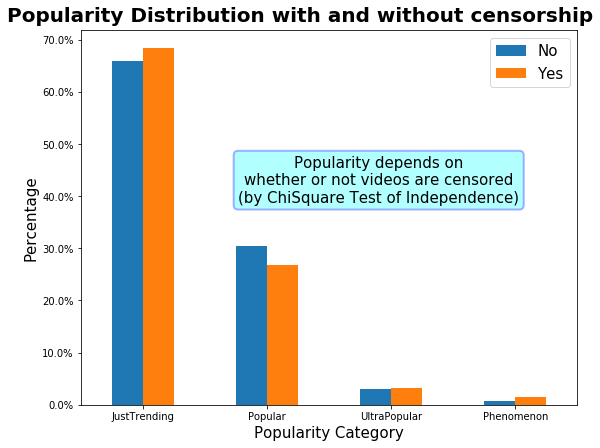

In [291]:
Country_Category_Popularity_DF['censorship'] = Country_Category_Popularity_DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
plot_popularity_distribution('censorship', "Popularity depends on\nwhether or not videos are censored\n(by ChiSquare Test of Independence)", 'Effect_of_Censorship_on_popularity.png', legend=["No", "Yes"])


## Study on Comment Moderation

Popularity depends on IsmoderatingComments (reject H0)


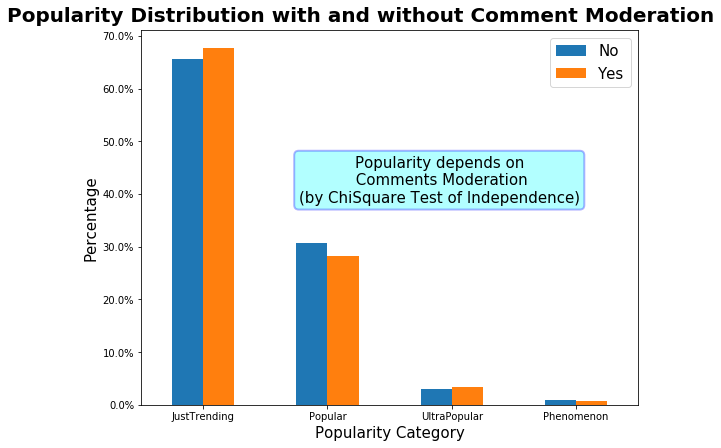

In [292]:
plot_popularity_distribution('IsmoderatingComments', "Popularity depends on\n Comments Moderation\n(by ChiSquare Test of Independence)", 'Effect_of_Comment_Moderation_on_popularity.png', legend=["No", "Yes"], title="Popularity Distribution with and without Comment Moderation" )



## Study on Google Analytics

Popularity depends on GoogleAnalyticsUsed (reject H0)


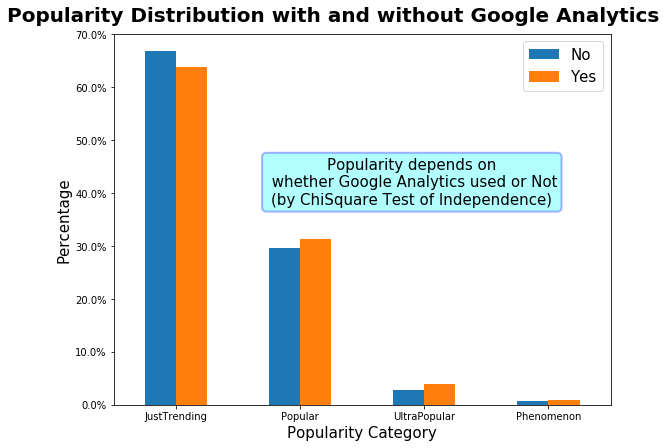

In [293]:
plot_popularity_distribution('GoogleAnalyticsUsed', "Popularity depends on\n whether Google Analytics used or Not\n(by ChiSquare Test of Independence)", 'Effect_of_Google_Analytics_on_popularity.png', legend=["No", "Yes"], title="Popularity Distribution with and without Google Analytics" )
